# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## Import Libraries

In [1]:
# python libraries
import os, sys
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd
from sklearn import decomposition, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import skew
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.python.client import device_lib
from helpers.helpers import *
from helpers.plots import *
from helpers.data_augment import *
from helpers.data_loader import *
from helpers.parameter_search import *
from density_forest.density_forest import *
from density_forest.helpers import *
from baselines.helpers import *
from keras_helpers.unet import *
from keras_helpers.callbacks import *

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # sys.argv[2]
print(device_lib.list_local_devices())

# plot in LaTeX style
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)

class_to_remove = 3  # int(sys.argv[1])
paramsearch = False  # search for best hyperparameters
my_dpi=255 # dpi of my screen, for image exporting

# data frame with previously found optimal hyperparameters
df_ps = pd.read_csv('models_out/hyperparams.csv', index_col=0) 
df_auroc = pd.read_csv('models_out/auroc_all.csv', index_col=0)
df_aucpr = pd.read_csv('models_out/aucpr_all.csv', index_col=0)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5438819790156509590
]


# Load Data

In [2]:
path = os.getcwd()

# data without overlap
print("loading data")
data_train = ZurichLoader(path, 'train', class_to_remove=class_to_remove)
data_val = ZurichLoader(path, 'val', class_to_remove=class_to_remove)
data_test = ZurichLoader(path, 'test', class_to_remove=class_to_remove)

print("loading data with overlap")
# data with overlap, for prediction
data_train_overlap = ZurichLoader(path, 'train', stride=32, inherit_loader=data_train)
data_val_overlap = ZurichLoader(path, 'val', stride=32, inherit_loader=data_val)
data_test_overlap = ZurichLoader(path, 'test', stride=32, inherit_loader=data_test)

# class names and colors
names = data_train.names
colors = data_train.colors
n_classes = 8
classes_to_keep = np.asarray([x for x in range(1, n_classes + 1) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

loading data
loading data with overlap
classes to keep: ['Roads' 'Buildings' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


In [3]:
colors_unseen = colors.copy()
colors_unseen[class_to_remove] = [.98, 0, .02]

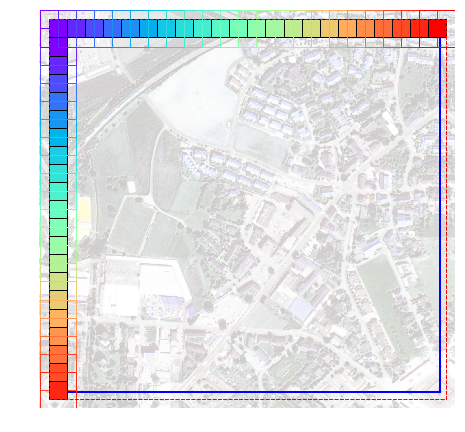

In [4]:
# export patch illustration
export_pad(data_train.imgs[0], 128, 64, s_name='../Figures/Zurich/im_padding.pdf', cmap=cm.rainbow)

In [5]:
for dataset, offset in zip([data_train, data_val, data_test], [0, 10, 15]):
    for im_idx, im in enumerate(dataset.imgs):
        im = im[..., :3]
        f_name = "../Figures/Zurich/Im/Im_" + str(im_idx + offset) + ".jpg"
        export_figure_matplotlib(im, f_name, dpi=my_dpi)

In [6]:
for dataset, offset in zip([data_train, data_val, data_test], [0, 10, 15]):
    for gt_idx, gt in enumerate(dataset.gt):
        gt_col = gt_label_to_color(gt, colors)*255
        f_name = "../Figures/Zurich/Im/GT_" + str(gt_idx + offset) + ".jpg"
        export_figure_matplotlib(gt_col, f_name, dpi=my_dpi)

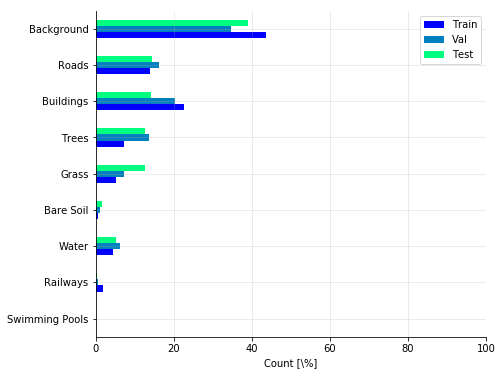

In [7]:
pred_labels_tr, cnt_tr = np.unique(data_train.gt_patches.astype('int'), return_counts=True)
pred_labels_val, cnt_val = np.unique(data_val.gt_patches.astype('int'), return_counts=True)
pred_labels_te, cnt_te = np.unique(data_test.gt_patches.astype('int'), return_counts=True)

cnt_tr = cnt_tr / np.sum(cnt_tr) * 100
cnt_val = np.concatenate((cnt_val / np.sum(cnt_val) * 100, [0]))
cnt_te = cnt_te / np.sum(cnt_te) * 100

df = pd.DataFrame({'Train': cnt_tr, 'Val': cnt_val, 'Test': cnt_te}, index=names[pred_labels_tr])

axis = df[::-1].plot.barh(figsize=(7, 6), colormap='winter')
plt.xlim([0, 100])
plt.xlabel("Count [\%]")
plt.grid(alpha=.3)
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)
plt.savefig("../Figures/Zurich/Pred_count/ZH_dist.pdf", bbox_inches='tight', pad_inches=0)

# CNN Training

In [8]:
"""
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))
"""

'\n# create copies of original data\ny_train_label = y_train.copy()\ny_val_label = y_val.copy()\ny_test_label = y_test.copy()\n\n# get class weights\nlabels_unique = np.unique(y_train.flatten())\nprint(labels_unique)\nclass_weights = class_weight.compute_class_weight(\'balanced\', labels_unique, y_train.flatten())\nclass_weights[0] = 0  # give less weight to background label class\nclass_weights[5] = 7  # give less weight to bare soil class\nclass_weights[8] = 7  # give less weight to swimming pool class\n\nprint("Class weights:")\nfor i, w in enumerate(class_weights):\n    print("%15s: %3.3f" % (names[i], w))\n'

In [9]:
"""

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))
"""

'\n\n# convert to numpy arrays\nx_train = np.asarray(x_train)\nx_val = np.asarray(x_val)\nx_test = np.asarray(x_test)\n\n# make y data categorical\ny_train = to_categorical(y_train_label, n_classes)\ny_val = to_categorical(y_val_label, n_classes)\n\ny_train = y_train[..., classes_to_keep]\ny_val = y_val[..., classes_to_keep]\nn_classes = len(classes_to_keep)\nclass_weights = class_weights[classes_to_keep]\n\n# print shapes of variables\nfor var in x_train, y_train, x_val, y_val:\n    print(np.shape(var))\n'

### Train CNN

In [10]:
"""
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   # callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)
                        
"""

'\n# callbacks (evaluated every epoch)\n# show loss and accuracy figures after each epoch\ncallback_plot = PlotLosses()\n\n# stop early if after several epochs the accuracy doesn\'t improve\ncallback_earlystop = EarlyStopping(monitor=\'val_loss\', min_delta=1e-4, patience=24, verbose=1, mode=\'auto\')\n\n# decrease learning rate when accuracy stops improving\ncallback_lr = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=12, verbose=1, mode=\'auto\',\n                                epsilon=1e-4, cooldown=0, min_lr=1e-8)\n\n# checkpoint to save weights at every epoch (in case of interruption)\nfile_path = "weights-improvement.hdf5"\ncallback_checkpoint = ModelCheckpoint(file_path, monitor=\'val_acc\', verbose=0, save_best_only=True, mode=\'max\')\n\ncallback_tensorboard = TensorBoard(log_dir=\'./tensorboard\', histogram_freq=0, write_graph=True, write_images=True)\n\n# model setup\nbatch_size = 20\nepochs = 300\n\n\ndef model_train(model, data_augmentation):\n    # Fit the 

In [11]:
# train or load model
# train the model
# model_unet = get_unet(n_classes, x_train.shape[1:])
# model_train(model_unet, data_augmentation=True)
# model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [12]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower().replace(" ", "") + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### Predictions

In [13]:
# get all predictions in training and test set
# training set
y_pred_tr = model_unet.predict(data_train_overlap.im_patches, verbose=1)
y_pred_tr = remove_overlap(data_train.imgs, y_pred_tr, 64, 32)
y_pred_label_tr = get_y_pred_labels(y_pred_tr, class_to_remove=class_to_remove, background=True)

# validation set
y_pred_val = model_unet.predict(data_val_overlap.im_patches, verbose=1)
y_pred_val = remove_overlap(data_val.imgs, y_pred_val, 64, 32)
y_pred_label_val = get_y_pred_labels(y_pred_val, class_to_remove=class_to_remove, background=True)

# test set
y_pred_te = model_unet.predict(data_test_overlap.im_patches, verbose=1)
y_pred_te = remove_overlap(data_test.imgs, y_pred_te, 64, 32)
y_pred_label_te = get_y_pred_labels(y_pred_te, class_to_remove=class_to_remove, background=True)

5223/5223 [==============================] - 173s 33ms/step


In [14]:
# get indices of correctly / incorrectly predicted pixels
# train
pred_t_tr = y_pred_label_tr == data_train.gt_patches
pred_f_tr = data_train.gt_patches == class_to_remove

# val
pred_t_val = y_pred_label_val == data_val.gt_patches
pred_f_val = data_val.gt_patches == class_to_remove

# test
pred_t_te = y_pred_label_te == data_test.gt_patches
pred_f_te = data_test.gt_patches == class_to_remove

In [15]:
# export predicted images
offset = 0
for dataset, preds in zip([data_train, data_val, data_test], [y_pred_label_tr, y_pred_label_val, y_pred_label_te]):
    imgs = convert_patches_to_image(dataset.imgs, preds[..., np.newaxis], 64, 64)
    for im_idx, im in enumerate(imgs):
        im_color = gt_label_to_color(im, colors) * 255
        f_name = "../Figures/Zurich/Im_pred/cl_" + str(class_to_remove)
        f_name = f_name + "/Im_" + str(im_idx + offset) + "_wo_cl_" + str(class_to_remove) + ".jpg"
        export_figure_matplotlib(im_color, f_name, dpi=my_dpi)
        
    offset += len(dataset.imgs)

### Accuracy Metrics (Test Set)

In [16]:
# Get oa, aa for train, val, test
# train
y_pred_tr_flattened = np.asarray(y_pred_label_tr.flatten()).astype('int')
y_tr_flattened = np.asarray(data_train.gt_patches.flatten()).astype('int')
filter_items = (y_tr_flattened != 0) & (y_tr_flattened != class_to_remove)
oa_tr = oa(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])
aa_tr, aa_tr_cl = aa(y_tr_flattened[filter_items], y_pred_tr_flattened[filter_items])

# val
y_pred_val_flattened = np.asarray(y_pred_label_val.flatten()).astype('int')
y_val_flattened = np.asarray(data_val.gt_patches.flatten()).astype('int')
filter_items = (y_val_flattened != 0) & (y_val_flattened != class_to_remove)
oa_val = oa(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])
aa_val, aa_val_cl = aa(y_val_flattened[filter_items], y_pred_val_flattened[filter_items])

# test
y_pred_te_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_te_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')
filter_items = (y_te_flattened != 0) & (y_te_flattened != class_to_remove)
oa_te = oa(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])
aa_te, aa_te_cl = aa(y_te_flattened[filter_items], y_pred_te_flattened[filter_items])

print(np.round(np.multiply([oa_tr, aa_tr], 100), 2))
print(np.round(np.multiply([oa_val, aa_val], 100), 2))
print(np.round(np.multiply([oa_te, aa_te], 100), 2))

[93.43 90.12]
[88.79 72.4 ]
[88.74 72.28]


In [17]:
# write metrics to CSV files
df_metrics = pd.read_csv('models_out/metrics_ND.csv', index_col=0)
df2 = pd.DataFrame({str(names[class_to_remove]): [oa_tr, aa_tr, oa_val, aa_val, oa_te, aa_te]},
                    index=['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models_out/metrics_ND.csv')
# print((df_metrics*100).round(2).to_latex())

In [18]:
# Accuracy metrics
y_pred_flattened = np.asarray(y_pred_label_te.flatten()).astype('int')
y_test_flattened = np.asarray(data_test.gt_patches.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
print(np.round(oa_te * 100, 2))

                precision    recall  f1-score   support

         Roads      0.847     0.884     0.865    794570
     Buildings      0.884     0.915     0.899    778708
         Grass      0.977     0.889     0.931    689620
     Bare Soil      0.637     0.752     0.690     88088
         Water      0.985     0.952     0.969    284293
      Railways      0.007     0.008     0.007     19190
Swimming Pools      0.000     0.000     0.000     10457

   avg / total      0.890     0.887     0.888   2664926

88.74


/anaconda3/envs/SIE-Master/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Distribution of predictions in unseen class

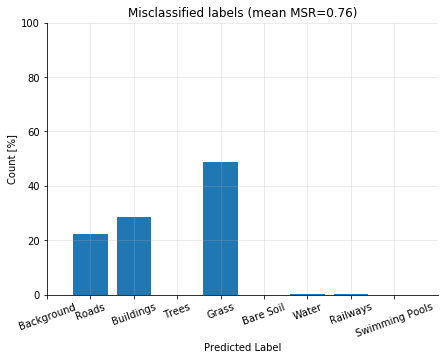

In [19]:
# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label_te[pred_f_te], return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(y_pred_te[pred_f_te])))
plt.xticks(pred_labels_te, names, rotation=20)
plt.savefig("../Figures/Zurich/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

# Novelty Detection

## Network

In [20]:
probas_msr = get_acc_net_msr(y_pred_te).flatten()
probas_margin = get_acc_net_max_margin(y_pred_te).flatten()
probas_entropy = get_acc_net_entropy(y_pred_te).flatten()

In [21]:
# precision-recall curves
y_true = pred_f_te.flatten()

# msr
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, -probas_msr)
pr_auc_msr = metrics.average_precision_score(y_true, -probas_msr)
auroc_msr = metrics.roc_auc_score(y_true, -probas_msr)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, -probas_msr)

# margin
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, -probas_margin)
pr_auc_margin = metrics.average_precision_score(y_true, -probas_margin)
auroc_margin = metrics.roc_auc_score(y_true, -probas_margin)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, -probas_margin)

# entropy
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, -probas_entropy)
pr_auc_entropy = metrics.average_precision_score(y_true, -probas_entropy)

auroc_entropy = metrics.roc_auc_score(y_true, -probas_entropy)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, -probas_entropy)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_msr, pr_auc_msr))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_margin, pr_auc_margin))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_entropy, pr_auc_entropy))

AUROC: 0.74, PR AUC: 0.24
AUROC: 0.74, PR AUC: 0.23
AUROC: 0.74, PR AUC: 0.24


In [22]:
# visualization
# MSR
probas_patches_msr = np.reshape(probas_msr, np.shape(data_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape(probas_margin, np.shape(data_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape(probas_entropy, np.shape(data_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

base_folder = "../Figures/Zurich/Im_cert/cl_" + str(class_to_remove)

In [23]:
acc_im_msr = convert_patches_to_image(data_test.imgs, probas_patches_msr[..., np.newaxis], 64, 64)
acc_im_margin = convert_patches_to_image(data_test.imgs, probas_patches_margin[..., np.newaxis], 64, 64)
acc_im_entropy = convert_patches_to_image(data_test.imgs, probas_patches_entropy[..., np.newaxis], 64, 64)

# export images
for img_idx in range(len(data_test.imgs)):
    # msr
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_msr_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_msr[img_idx], f_name, dpi=my_dpi)
    
    # margin
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_margin_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_margin[img_idx], f_name, dpi=my_dpi)
    
    # entropy
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_entropy_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_entropy[img_idx], f_name, dpi=my_dpi)

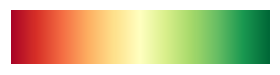

In [24]:
# export colorbar
a = np.array([[0, 1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="RdYlGn")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.1, 0.4, 0.5])
cb = plt.colorbar(orientation="horizontal", cax=cax)
cb.outline.set_linewidth(0)
plt.axis('off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("../Figures/Zurich/Im_cert/colorbar.pdf", bbox_inches='tight', pad_inches=0)

## Dropout

In [25]:
# get predictions
y_preds = predict_with_dropout_imgs(model_unet, data_test_overlap, batch_size=500, n_iter=10)

100%|██████████| 10/10 [31:41<00:00, 190.10s/it]


In [26]:
# get prediction and confidence
prediction = np.mean(y_preds, 0)
probas_dropout = get_acc_net_entropy(prediction)
del y_preds  # free memory

In [27]:
# dropout metrics
y_scores = -probas_dropout.flatten()
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.average_precision_score(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

AUROC: 0.75, PR AUC: 0.24


In [28]:
# visualization
probas_patches_dropout = np.reshape(probas_dropout, np.shape(data_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
acc_im_dropout = convert_patches_to_image(data_test.imgs, probas_patches_dropout[..., np.newaxis], 64, 64)
for img_idx in range(len(data_test.imgs)):
    # export
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_dropout_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_dropout[img_idx], f_name, dpi=my_dpi)

## Retrieve Activations, PCA, t-SNE

In [29]:
# get activations for training Density Forest
act_train_all = get_activations_batch(model_unet, -2, data_train_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_train_all = remove_overlap(data_train.imgs, act_train_all, patch_size=64, stride=32)
act_train = act_train_all[pred_t_tr]

100%|██████████| 782/782 [10:30<00:00,  1.24it/s]


In [ ]:
# get activations
act_val_all = get_activations_batch(model_unet, -2, data_val_overlap.im_patches, 20, verbose=True)

# retain only activation weights for which there is a ground truth
act_val_all = remove_overlap(data_val.imgs, act_val_all, patch_size=64, stride=32)
act_val = act_val_all[pred_t_val]

 64%|██████▍   | 167/259 [02:23<01:19,  1.16it/s]

In [34]:
# get activations for testing Density Forest
act_test = get_activations_batch(model_unet, -2, data_test_overlap.im_patches, 20, verbose=True)

# remove test activations overlap
act_test = remove_overlap(data_test.imgs, act_test, patch_size=64, stride=32)
act_test = np.concatenate(np.concatenate(act_test))


100%|██████████| 262/262 [03:17<00:00,  1.33it/s]


In [35]:
# get balanced data subset to show in figure
tsne_pts_per_class = 200
dataset_subset_indices = get_balanced_subset_indices(data_test.gt_patches.flatten(), 
                                                     np.arange(1, 9), pts_per_class=tsne_pts_per_class)
dataset_subset_indices = np.concatenate(dataset_subset_indices)

In [36]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
tsne_y = data_test.gt_patches.flatten()[dataset_subset_indices]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.016s...
[t-SNE] Computed neighbors for 1600 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.705037
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.552582
[t-SNE] Error after 500 iterations: 0.516899


In [37]:
colors[-2] = [1., 1, 0] 

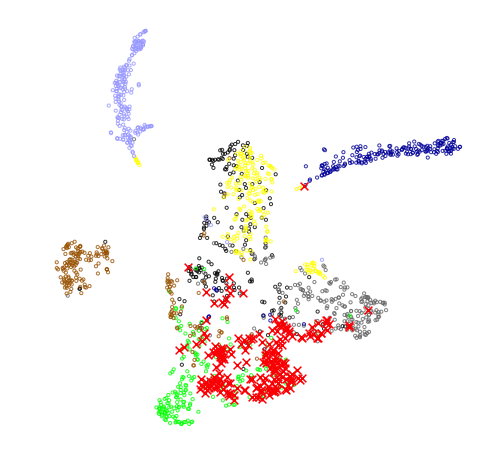

In [38]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors_unseen, class_to_remove=class_to_remove)
plt.savefig("../Figures/Zurich/tSNE/t-SNE_wo_cl" + str(class_to_remove) + "_before_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [39]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(act_test)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))
act_train = pca.transform(act_train)

act_val_all = pca.transform(np.concatenate(np.concatenate(act_val_all)))
act_val = pca.transform(act_val)

# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.97


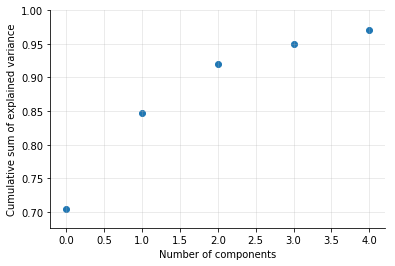

In [40]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("../Figures/Zurich/PCA/ZH_pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [41]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[dataset_subset_indices])
# tsne without unseen class
tsne_train = tsne_all[tsne_y != class_to_remove]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.002s...
[t-SNE] Computed neighbors for 1600 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 1.523811
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.051266
[t-SNE] Error after 500 iterations: 0.511652


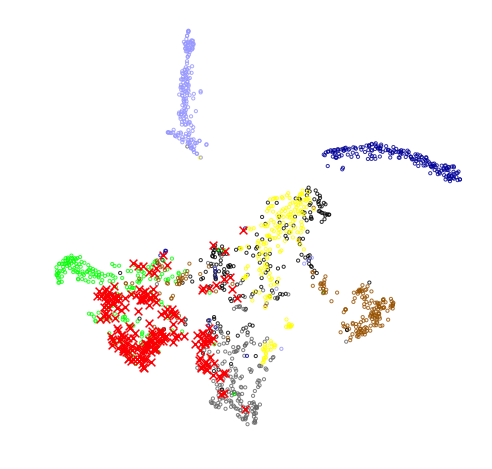

In [42]:
# plot
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors_unseen, class_to_remove=class_to_remove)

plt.savefig("../Figures/Zurich/tSNE/t-SNE_wo_cl" + str(class_to_remove) + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

Variance explained by first 3 components: 0.92


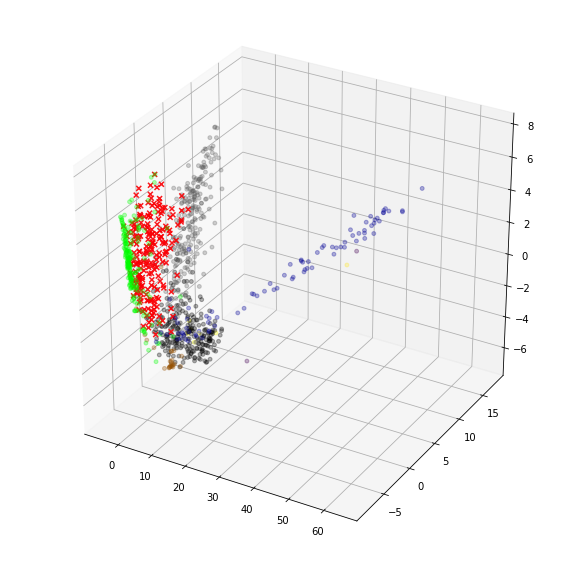

In [43]:
# plot first 3 PCA components
plot_pts_3d(act_test[:, :3], data_test.gt_patches.flatten(), classes_to_keep, colors_unseen,
            class_to_remove=class_to_remove, subsample_pct=.0003,
            s_name='../Figures/Zurich/PCA/pca_components_3d_' + str(names[class_to_remove]) + '.pdf')

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 2 components: 0.85


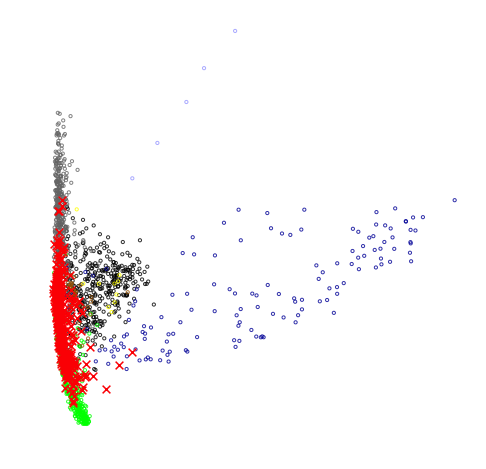

In [44]:
# plot first 2 PCA components
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
plot_pts_2d(act_test[:, :2], data_test.gt_patches.flatten(), ax, classes_to_keep, colors_unseen,
            class_to_remove=class_to_remove, subsample_pct=.0005,
            s_name='../Figures/Zurich/PCA/pca_components_2d_' + str(names[class_to_remove]) + '.pdf')
print("Variance explained by first 2 components: %.2f" % np.sum(pca.explained_variance_ratio_[:2]))

## GMM

In [45]:
# parameter search
if paramsearch:
    tuned_parameters = [{'n_components': np.arange(3, 10), 'max_iter': [10000]}]
    # do parameter search
    ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train, act_train_all,
                             pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                             n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.01)
    ps_gmm.fit()
    best_params_gmm = ps_gmm.best_params
else:
    best_params_gmm = {'n_components': df_ps.loc[str(names[class_to_remove])]['gmm_n_components'], 'max_iter': 10000}

print(best_params_gmm)

{'n_components': 4, 'max_iter': 10000}


In [46]:
# Fit GMM
gmm = GaussianMixture(**best_params_gmm)
gmm.fit(draw_subsamples(act_train, .1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [47]:
# Predict
probas_gmm = gmm.score_samples(act_test)

In [48]:
# TODO divide y axis

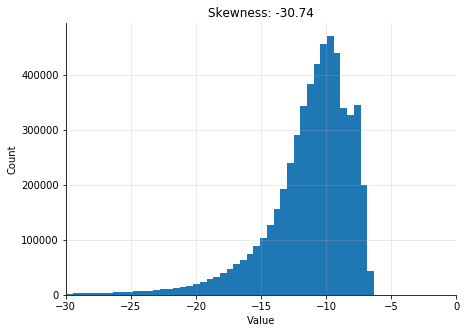

In [49]:
# original histogram
fig = plt.figure(figsize=(7, 5))
_ = plt.hist(probas_gmm, bins=1000)
plt.xlim([-30, 0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title('Skewness: %.2f' % skew(probas_gmm))
plt.savefig("../Figures/Zurich/Skew/Skew_GMM_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

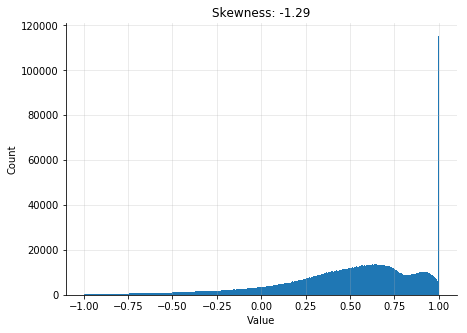

In [50]:
# stretched histogram
p2 = np.percentile(probas_gmm, 2)
p98 = np.percentile(probas_gmm, 98)
probas_gmm_s = exposure.rescale_intensity(probas_gmm, in_range=(p2, p98))  # stretch

fig = plt.figure(figsize=(7, 5))
_ = plt.hist(probas_gmm_s, bins=1000)
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title('Skewness: %.2f' % skew(probas_gmm_s))
plt.savefig("../Figures/Zurich/Skew/Skew_GMM_wo_cl" + str(class_to_remove) + "_stretched.pdf",
            bbox_inches='tight', pad_inches=0)

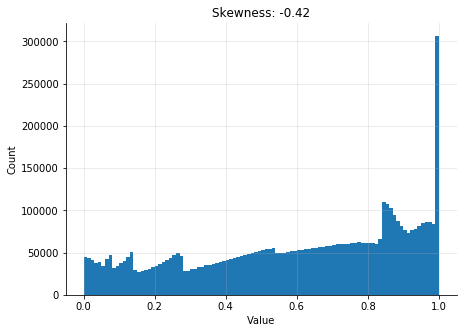

In [51]:
# equalized histogram
fig = plt.figure(figsize=(7, 5))
_ = plt.hist(exposure.equalize_hist(probas_gmm), bins=100)
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title('Skewness: %.2f' % skew(exposure.equalize_hist(probas_gmm)))
plt.savefig("../Figures/Zurich/Skew/Skew_GMM_wo_cl" + str(class_to_remove) + "_eq.pdf",
            bbox_inches='tight', pad_inches=0)

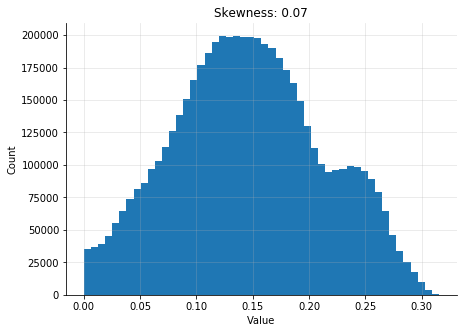

In [52]:
fig = plt.figure(figsize=(7, 5))
_ = plt.hist(1.2 ** probas_gmm, bins=50)
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title('Skewness: %.2f' % skew(1.2 ** probas_gmm))
plt.savefig("../Figures/Zurich/Skew/Skew_GMM_wo_cl" + str(class_to_remove) + "_corr.pdf",
            bbox_inches='tight', pad_inches=0)

In [53]:
# precision-recall curve
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, -probas_gmm)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)

# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, -probas_gmm)
auroc_gmm = metrics.roc_auc_score(y_true, -probas_gmm)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

AUROC: 0.66, PR AUC: 0.23


In [54]:
# visualization
probas_patches_gmm = np.reshape(probas_gmm, np.shape(data_test.gt_patches))

# show image of DF uncertainty vs. max margin uncertainty
acc_im_gmm = convert_patches_to_image(data_test.imgs, probas_patches_gmm[..., np.newaxis], 64, 64)
for img_idx in range(len(data_test.imgs)):
    # original 
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_gmm[img_idx], f_name, dpi=my_dpi)
    
    # equalized
    acc_im_gmm_ = exposure.equalize_hist(acc_im_gmm[img_idx])
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + "_eq.jpg"
    export_figure_matplotlib(acc_im_gmm_, f_name, dpi=my_dpi)
    
    # strethed
    p2 = np.percentile(acc_im_gmm[img_idx], 2)
    p98 = np.percentile(acc_im_gmm[img_idx], 98)
    acc_im_gmm_stretched = exposure.rescale_intensity(acc_im_gmm[img_idx], (p2, p98))
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + "_stretched.jpg"
    export_figure_matplotlib(acc_im_gmm_stretched, f_name, dpi=my_dpi)
    
    # de-skewed
    acc_im_gmm_ = np.exp(1.2 ** acc_im_gmm[img_idx])
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + "_deskew.jpg"
    export_figure_matplotlib(acc_im_gmm_, f_name, dpi=my_dpi)

# SVM

In [55]:
act_train_svm = preprocessing.scale(act_train)
act_train_all_svm = preprocessing.scale(act_train_all)
act_val_all_svm = preprocessing.scale(act_val_all)
act_test_svm = preprocessing.scale(act_test)

In [56]:
# parameter search
paramsearch=True
if paramsearch:
    tuned_parameters = [{'kernel': ['rbf'],
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'degree':[1]
                         },
                        {'kernel': ['poly'],
                         'degree': np.arange(1, 5),
                         'nu': [1e-2, 1e-1, 5e-1],
                         'max_iter': [10000]}]

    # do parameter search
    ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm, act_val_all_svm,
                             pred_f_val.flatten(), scorer_roc_probas_svm, n_iter=20,
                             verbosity=11, n_jobs=-1, subsample_train=.001, subsample_test=.01)
    ps_svm.fit()
    best_params_svm = ps_svm.best_params
else:
    best_params_svm = {'kernel': df_ps.loc[str(names[class_to_remove])]['oc-svm_k'], 
                       'degree': df_ps.loc[str(names[class_to_remove])]['oc-svm_deg'], 
                       'nu': df_ps.loc[str(names[class_to_remove])]['oc_svm_nu'],
                       'max_iter': 100}
    
print(best_params_svm)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   33.7s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   34.7s
[Parallel(n_jobs=8)]: Done   4 out of  17 | elapsed:   36.8s remaining:  2.0min
[Parallel(n_jobs=8)]: Done   6 out of  17 | elapsed:  1.0min remaining:  1.9min
[Parallel(n_jobs=8)]: Done   8 out of  17 | elapsed:  1.2min remaining:  1.4min
[Parallel(n_jobs=8)]: Done  10 out of  17 | elapsed:  1.7min remaining:  1.2min
[Parallel(n_jobs=8)]: Done  12 out of  17 | elapsed:  2.1min remaining:   51.5s
[Parallel(n_jobs=8)]: Done  14 out of  17 | elapsed:  2.6min remaining:   34.0s


{'degree': 3, 'kernel': 'poly', 'max_iter': 10000, 'nu': 0.5}


[Parallel(n_jobs=8)]: Done  17 out of  17 | elapsed:  3.2min finished


In [57]:
# Fit SVM
clf_svm = svm.OneClassSVM(**best_params_svm)

clf_svm.fit(draw_subsamples(act_train_svm, .001))

# predict confidence (distance from separating plane, positive for inliers, negative for outliers)
probas_svm = clf_svm.decision_function(act_test_svm)

In [58]:
# metrics
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, -probas_svm)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, -probas_svm)
auroc_svm = metrics.roc_auc_score(y_true, -probas_svm)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_svm, pr_auc_svm))

AUROC: 0.78, PR AUC: 0.26


In [59]:
# visualization
probas_patches_svm = np.reshape(probas_svm, np.shape(data_test.gt_patches))

# show image of DF uncertainty vs. max margin uncertainty
acc_im_svm = convert_patches_to_image(data_test.imgs, probas_patches_svm[..., np.newaxis], 64, 64)

for img_idx in range(len(data_test.imgs)):
    # original
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_svm_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_svm[img_idx], f_name, dpi=my_dpi)
    
    # equalized
    acc_im_svm_ = exposure.equalize_hist(acc_im_svm[img_idx])
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_svm_im_" + str(img_idx) + "_eq.jpg"
    export_figure_matplotlib(acc_im_svm_, f_name, dpi=my_dpi)

#### Visualize Kernels

In [60]:
subset_ind = get_balanced_subset_indices(data_train.gt_patches.flatten(), classes_to_keep, pts_per_class=150)

subsample = act_train_all_svm[np.concatenate(subset_ind)]

In [61]:
# RBF
K = RBF()
K_X = K.__call__(subsample)
K_X = exposure.equalize_hist(K_X)
f_name = "../Figures/Zurich/Kernels/Kernel_RBF_wo_cl_" + str(class_to_remove) + ".jpg" 
export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

# polynomial
for deg in [1, 2, 3]:
    K_X = metrics.pairwise.polynomial_kernel(subsample, degree=deg)
    # contrast stretching
    p2, p98 = np.percentile(K_X, (2, 98))
    K_X = exposure.rescale_intensity(K_X, in_range=(p2, p98))

    f_name = "../Figures/Zurich/Kernels/Kernel_poly_wo_cl_" + str(class_to_remove) + "_deg_" + str(deg) + ".jpg"
    export_figure_matplotlib(K_X, f_name, dpi=my_dpi)

## Density Forest

In [62]:
# Create DensityForest instance
clf_df = DensityForest(max_depth=2, min_subset=.1, n_trees=100,
                       subsample_pct=.1, n_jobs=-1, verbose=10,
                       ig_improvement=.4)

In [63]:
# fit to training data
clf_df.fit(tsne_train)

Number of points on which to train each tree: 140
Minimum number of points in each leaf: 14


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    4.0s


Number of created root nodes: 100
Mean number of clusters created per tree: 4


[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    4.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


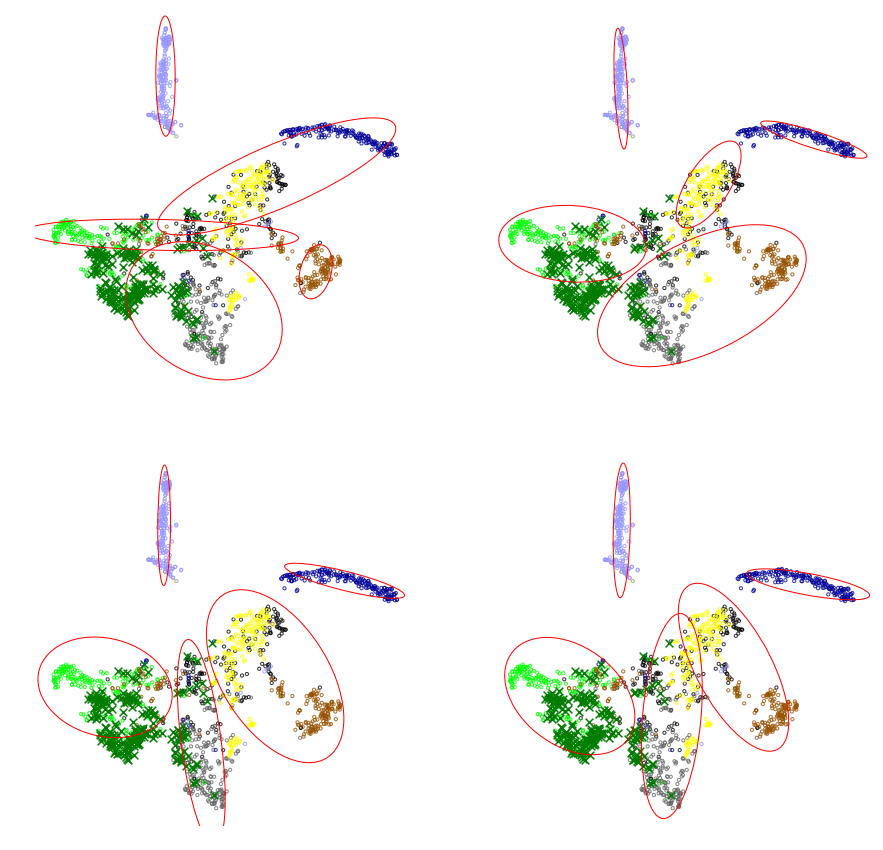

In [64]:
# Show ellipses on plot
_, axes = plt.subplots(2, 2, figsize=(15, 15)) 
for i in range(4):
    plot_pts_2d(tsne_all, tsne_y, axes[int(i/2)][np.mod(i, 2)], classes_to_keep, 
                colors, class_to_remove=class_to_remove)
    axes[int(i/2)][np.mod(i, 2)].set_axis_off()
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(axes[int(i / 2)][np.mod(i, 2)], means, covs)

In [65]:
# export some ellipses for GIF
for i in range(10):
    _, ax = plt.subplots(1, 1, figsize=(8, 8)) 
    plt.xlim([-50, 50])
    plt.ylim([-50, 50])
    plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, 
                class_to_remove=class_to_remove, names=names)
    covs, means = get_clusters(clf_df.root_nodes[i], [], [])
    plot_ellipses(ax, means, covs)
    plt.axis('off')
    # plt.savefig("../Figures/Zurich/GIF/TSNE_act_wo_cl" + str(class_to_remove) + "_"+str(i)+".pdf", 
    #              bbox_inches='tight', pad_inches=0)
    plt.close()

### Fit on real data

In [67]:
paramsearch=False

In [68]:
# parameter search
default_params = {'n_trees': 10, 'n_max_dim': 0, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .0001, 'min_subset': 0}

if paramsearch:
    """search for best hyperparameters"""
    tuned_params = [{'max_depth': [1, 2, 3],
                     'ig_improvement': [0, .4, .7]
                    }]

    # do parameter search
    ps_df = ParameterSearch(DensityForest, tuned_params, act_train, act_val_all,
                            pred_f_val.flatten(), scorer_roc_probas_df,
                            n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                            subsample_test=.1, default_params=default_params)

    print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
    print(ps_df.combinations)
    ps_df.fit()
    print(ps_df.best_params)
    
    # Create DensityForest instance
    best_params_df = ps_df.best_params
    
else:
    """use previously found hyperparameters"""
    best_params_df = {'max_depth': df_ps.loc[str(names[class_to_remove])]['df_depth'],
                      'ig_improvement': df_ps.loc[str(names[class_to_remove])]['df_min_ig']}
    
    
print(best_params_df)
default_params['verbose'] = 1
default_params['batch_size'] = 10000

{'max_depth': 2, 'ig_improvement': 0.4}


In [69]:
# fit DF with best found parameters
clf_df = DensityForest(**best_params_df, **default_params)
clf_df.fit(act_train)

# get probabilities for all images
probas_df = clf_df.decision_function(act_test)

Number of points on which to train each tree: 751
Minimum number of points in each leaf: 0


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.6s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Number of created root nodes: 10
Mean number of clusters created per tree: 8
Total steps: 550
Number of jobs: 8 


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   56.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 549 out of 549 | elapsed:  2.8min finished


### Post-Treatment

### Metrics

In [70]:
# metrics
# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, -probas_df)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, -probas_df)
auroc_df = metrics.roc_auc_score(y_true, -probas_df)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.55, PR AUC: 0.13


In [71]:
probas_df -= np.min(probas_df)
probas_df /= np.max(probas_df)

In [72]:
# visualization
probas_patches_df = np.reshape(probas_df, np.shape(data_test.gt_patches))

# show image of DF uncertainty vs. max margin uncertainty
acc_im_df = convert_patches_to_image(data_test.imgs, probas_patches_df[..., np.newaxis], 64, 64)
for img_idx in range(len(data_test.imgs)):
    # original
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + ".jpg"
    export_figure_matplotlib(acc_im_df[img_idx], f_name, dpi=my_dpi)
    
    # equalized
    acc_im_df_= exposure.equalize_hist(acc_im_df[img_idx])
    f_name = base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + "_eq.jpg"
    export_figure_matplotlib(acc_im_df_, f_name, dpi=my_dpi)

## Plot Results

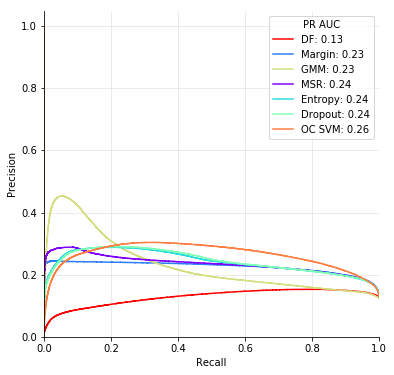

In [73]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("../Figures/Zurich/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", 
            bbox_inches='tight', pad_inches=0)

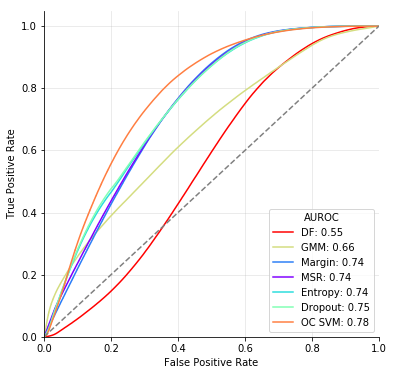

In [74]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.plot(fprs[i], tprs[i], c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("../Figures/Zurich/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", 
            bbox_inches='tight', pad_inches=0)

In [75]:
# write best hyperparameters to CSV file
best_params = {'gmm_n_components': best_params_gmm['n_components'], 
               'oc-svm_k': best_params_svm['kernel'], 
               'oc-svm_deg': best_params_svm['degree'], 
               'oc_svm_nu': best_params_svm['nu'], 
               'df_depth': best_params_df['max_depth'], 
               'df_min_ig': best_params_df['ig_improvement']}

In [76]:
# write results to CSV files
# hyperparameters
df2 = pd.DataFrame(best_params, index=[str(names[class_to_remove])])
df_ps = df_ps.append(df2)
df_ps = df_ps[~df_ps.index.duplicated(keep='last')]  # avoid duplicates
df_ps.to_csv('models_out/hyperparams.csv')

# AUROC
df2 = pd.DataFrame({str(names[class_to_remove]): scores_auc}, index=names_methods).T
df_auroc = df_auroc.append(df2)
df_auroc = df_auroc[~df_auroc.index.duplicated(keep='last')]  # avoid duplicates
df_auroc.to_csv('models_out/auroc_all.csv')


# PR AUC
df2 = pd.DataFrame({str(names[class_to_remove]): scores_pr}, index=names_methods).T
df_aucpr = df_aucpr.append(df2)
df_aucpr = df_aucpr[~df_aucpr.index.duplicated(keep='last')]  # avoid duplicates
df_aucpr.to_csv('models_out/aucpr_all.csv')

In [77]:
# load auroc df with previously saved results
df_auroc = pd.read_csv('models_out/auroc_all.csv', index_col=0)

In [78]:
# reorder by class names
df_auroc = df_auroc.reindex(names[1:])
df_auroc.to_csv('models_out/auroc_all.csv')

In [79]:
# show latex table of AUROC metrics for all methods
print(df_auroc.round(2).to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   MSR &  Margin &  Entropy &  Dropout &   GMM &  OC SVM &    DF \\
\midrule
Roads          &  0.60 &    0.59 &     0.61 &     0.59 &  0.66 &    0.52 &  0.70 \\
Buildings      &  0.65 &    0.66 &     0.65 &     0.65 &  0.58 &    0.62 &  0.61 \\
Trees          &  0.74 &    0.74 &     0.74 &     0.75 &  0.66 &    0.78 &  0.55 \\
Grass          &  0.38 &    0.37 &     0.39 &     0.39 &  0.47 &    0.24 &  0.55 \\
Bare Soil      &  0.68 &    0.70 &     0.63 &     0.59 &  0.66 &    0.67 &  0.65 \\
Water          &  0.59 &    0.60 &     0.58 &     0.58 &  0.59 &    0.79 &  0.66 \\
Railways       &  0.57 &    0.59 &     0.53 &     0.54 &  0.55 &    0.69 &  0.40 \\
Swimming Pools &  0.26 &    0.28 &     0.23 &     0.28 &  0.99 &    0.97 &  0.99 \\
\bottomrule
\end{tabular}



In [80]:
# show best method for each left-out class
print(df_auroc.T.idxmax())

Roads                 DF
Buildings         Margin
Trees             OC SVM
Grass                 DF
Bare Soil         Margin
Water             OC SVM
Railways          OC SVM
Swimming Pools        DF
dtype: object


In [81]:
# show mean aourc for each method
print(df_auroc.mean().round(2))

MSR        0.56
Margin     0.57
Entropy    0.55
Dropout    0.54
GMM        0.65
OC SVM     0.66
DF         0.64
dtype: float64


In [82]:
df_ps

,gmm_n_components,oc-svm_k,oc-svm_deg,oc_svm_nu,df_depth,df_min_ig
Roads,3,poly,2,0.001,1,-inf
Buildings,5,poly,3,0.010,3,0.400000
Grass,3,poly,1,0.001,3,0.000000
Bare Soil,9,poly,1,0.500,3,0.700000
Water,3,poly,1,0.001,1,0.000000
Railways,5,poly,3,0.500,3,0.400000
Swimming Pools,3,rbf,1,0.500,3,0.700000
Trees,4,poly,3,0.500,2,0.400000


In [83]:
# show mean aourc for each method
print(df_ps.to_latex())

\begin{tabular}{lrlrrrr}
\toprule
{} &  gmm\_n\_components & oc-svm\_k &  oc-svm\_deg &  oc\_svm\_nu &  df\_depth &  df\_min\_ig \\
\midrule
Roads          &                 3 &     poly &           2 &      0.001 &         1 &       -inf \\
Buildings      &                 5 &     poly &           3 &      0.010 &         3 &   0.400000 \\
Grass          &                 3 &     poly &           1 &      0.001 &         3 &   0.000000 \\
Bare Soil      &                 9 &     poly &           1 &      0.500 &         3 &   0.700000 \\
Water          &                 3 &     poly &           1 &      0.001 &         1 &   0.000000 \\
Railways       &                 5 &     poly &           3 &      0.500 &         3 &   0.400000 \\
Swimming Pools &                 3 &      rbf &           1 &      0.500 &         3 &   0.700000 \\
Trees          &                 4 &     poly &           3 &      0.500 &         2 &   0.400000 \\
\bottomrule
\end{tabular}



# Interesting objects  with low confidence

In [84]:
my_dpi = 255

In [85]:
def export_particularity(dataset, img_idx, x, y, width, height, colors, confs_patches=None, names=None, dir_out=None,
                         idx=0, dpi=255):
    """
    export detail view of interesting image: image with blue rectangle, cropped region, cropped GT, cropped conf images
    """
    # Image
    class_to_remove = dataset.class_to_remove
    im = dataset.imgs[img_idx][..., :3]
    max_x = np.mod(im.shape[0], 32)
    max_y = np.mod(im.shape[1], 32)
    im = im[:-max_x, :-max_y]
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='b', alpha=.5)
    f_name = dir_out + 'im_' + str(img_idx) + '_obj_' + str(idx) + '_im.jpg'
    _ = export_figure_matplotlib(im, dpi=dpi, rect=rect, f_name=f_name)
    plt.close()

    # Cropped Image
    im_crop = im[y:(y + height), x:(x + width)]
    f_name = dir_out + 'im_' + str(img_idx) + '_obj_' + str(idx) + '_im_crop.jpg'
    _ = export_figure_matplotlib(im_crop, dpi=dpi, f_name=f_name)
    plt.close()

    # GT
    rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='b', facecolor='None')
    im_gt = gt_label_to_color(dataset.gt[img_idx], colors) * 255
    max_x = np.mod(im_gt.shape[0], 32)
    max_y = np.mod(im_gt.shape[1], 32)
    im_gt = im_gt[:-max_x, :-max_y]
    f_name = dir_out + 'im_' + str(img_idx) + '_obj_' + str(idx) + '_gt.jpg'
    _ = export_figure_matplotlib(im_gt, dpi=dpi, rect=rect, f_name=f_name)
    plt.close()

    if confs_patches is not None:
        for idx_conf, conf_patches in enumerate(confs_patches):
            conf_imgs = convert_patches_to_image(dataset.imgs, conf_patches[..., np.newaxis], 64, 64)
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='b', facecolor='None')
            f_name = dir_out + 'im_' + str(img_idx) + '_obj_' + str(idx) + '_' + names[idx_conf] + '_wo_cl_' + str(
                class_to_remove) + '.jpg'
            export_figure_matplotlib(conf_imgs[img_idx], dpi=dpi, rect=rect, f_name=f_name)
            plt.close()

In [86]:
names_confs_patches = ['msr', 'df']
confs_patches = [probas_patches_msr, probas_patches_df]

In [87]:
dir_out = '../Figures/Zurich/Detail/im1/'
export_particularity(data_test, 1, 270, 660, 200, 200, colors, dir_out=dir_out, confs_patches=confs_patches,
                     names=names_confs_patches, idx=1, dpi=my_dpi)

In [88]:
dir_out = '../Figures/Zurich/Detail/im4/'
export_particularity(data_test, 4, 670, 550, 450, 320, colors, dir_out=dir_out, confs_patches=confs_patches, 
                     names=names_confs_patches, idx=1, dpi=my_dpi)

# Plot confidence in t-SNE

In [89]:
pred_f_tsne = data_test.gt_patches == class_to_remove
pred_t_tsne = (data_test.gt_patches != class_to_remove) & (data_test.gt_patches != 0)

In [90]:
# indices of correctly / wrongly predicted points
pred_f = pred_f_tsne.flatten()[dataset_subset_indices]
pred_t = pred_t_tsne.flatten()[dataset_subset_indices]
probas_methods = [probas_msr, probas_margin, probas_entropy, probas_dropout.flatten(), probas_gmm, 
                  np.squeeze(probas_svm), np.squeeze(probas_df)].copy()

base_dir = "../Figures/Zurich/Im_cert/cl_" + str(class_to_remove) + "/"

names_methods_save = ['net_msr', 'net_margin', 'net_entropy', 'dropout', 'gmm', 'svm', 'df']
for proba, name in zip(probas_methods, names_methods_save):
    probas_tsne = proba[dataset_subset_indices]
    #probas_tsne = np.argsort(probas_tsne)/len(probas_tsne)

    # colors
    probas_df_c = exposure.equalize_hist(probas_tsne)
    probas_df_c -= np.min(probas_df_c)
    probas_df_c /= np.max(probas_df_c)
    colors_plt = plt.cm.RdYlGn(probas_df_c)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 
    # indicators of least confident points    
    # plot correctly predicted points (o marker)

    ax.scatter(tsne_all[:, 0][pred_t], tsne_all[:, 1][pred_t], c=colors_plt[pred_t], alpha=.1)

    # plot incorrectly predicted points (x marker)
    ax.scatter(tsne_all[:, 0][pred_f], tsne_all[:, 1][pred_f], c=colors_plt[pred_f], edgecolors='black',
               linewidths=.5, s=90)
    ax.set_axis_off()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    f_name = base_dir + "t-SNE_wo_cl_" + str(class_to_remove) + "_" + str(name) + ".pdf"
    plt.savefig(f_name, bbox_inches=extent, pad_inches=0)
    ax.legend(['Seen points', 'Novel points'])
    plt.close()